<a href="https://colab.research.google.com/github/nerone19/IndoorOD/blob/main/indoor_Od.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [454]:
import xml.etree.ElementTree as ET
import pdb 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [455]:
xml_file = ("dataset/annotation/annotation_s1.xml")
tree = ET.parse(xml_file)

In [456]:
tree

In [457]:
def readXml(tree):
    root = tree.getroot()

    boxes_for_class_in_file = {}
    boxes_for_file = [] 
    for files in root.iter('image'):
      filename = files.attrib['file']
      boxes_for_class_in_file[filename] = {}
      class_in_file = {}
      for boxes in files.iter('box'):
        coords_list = [boxes.attrib['top'],boxes.attrib['left'],boxes.attrib['width'],boxes.attrib['height']]
        class_name = boxes[0].text

        if class_name not in class_in_file:
          class_in_file[class_name] = [] 
          
        class_in_file[class_name].append(coords_list)
      # pdb.set_trace()
      for found_class in class_in_file.keys():
        boxes_for_class_in_file[filename][found_class] = {}
        boxes_for_class_in_file[filename][found_class]  = class_in_file[found_class]
    return boxes_for_class_in_file

read all the xml files

In [458]:
final_dict = {}
for xml in os.listdir('dataset/annotation'):
  if(xml.split('.')[1] =='xml'):
    xml_file = ( os.path.join('dataset/annotation', xml))
    tree = ET.parse(xml_file)
    dict = readXml(tree)
    final_dict.update(dict)

unique classes in the dictionary

In [459]:
s = set( c for file in final_dict.keys() for c in final_dict[file].keys())
s

{'chair', 'clock', 'exit', 'fireextinguisher', 'printer', 'screen', 'trashbin'}

convert into dataframe

In [460]:
df = pd.DataFrame.from_dict(final_dict)
#we want filenames as rows(we transpose the df)
df = df.T

In [461]:
df.head()

,exit,fireextinguisher,clock,chair,trashbin,printer,screen
frame_s1_1.jpg,"[[244, 500, 192, 99], [358, 742, 218, 105]]",NaN,NaN,NaN,NaN,NaN,NaN
frame_s1_10.jpg,NaN,"[[97, 651, 79, 81], [354, 667, 109, 281]]",NaN,NaN,NaN,NaN,NaN
frame_s1_100.jpg,NaN,NaN,"[[159, 460, 172, 169]]",NaN,NaN,NaN,NaN
frame_s1_101.jpg,NaN,NaN,NaN,"[[114, 577, 238, 303], [90, 143, 231, 375]]",NaN,NaN,NaN
frame_s1_102.jpg,NaN,NaN,NaN,"[[69, 814, 307, 433], [10, 218, 440, 550]]",NaN,NaN,NaN


In [462]:
for col in df.columns.values:
  df[col+"_count"] = df[col].apply(lambda x: len(x) if isinstance(x, list) else 0 )

In [463]:
col_counts = ['exit_count','fireextinguisher_count','clock_count','chair_count','trashbin_count',	'printer_count',	'screen_count']
count_list = [] 
for col in col_counts:
  sum = df[col].sum()
  count_list.append(sum)
  print("{} counts for colunm {}".format(sum,col))

545 counts for colunm exit_count
1684 counts for colunm fireextinguisher_count
280 counts for colunm clock_count
1662 counts for colunm chair_count
228 counts for colunm trashbin_count
81 counts for colunm printer_count
115 counts for colunm screen_count


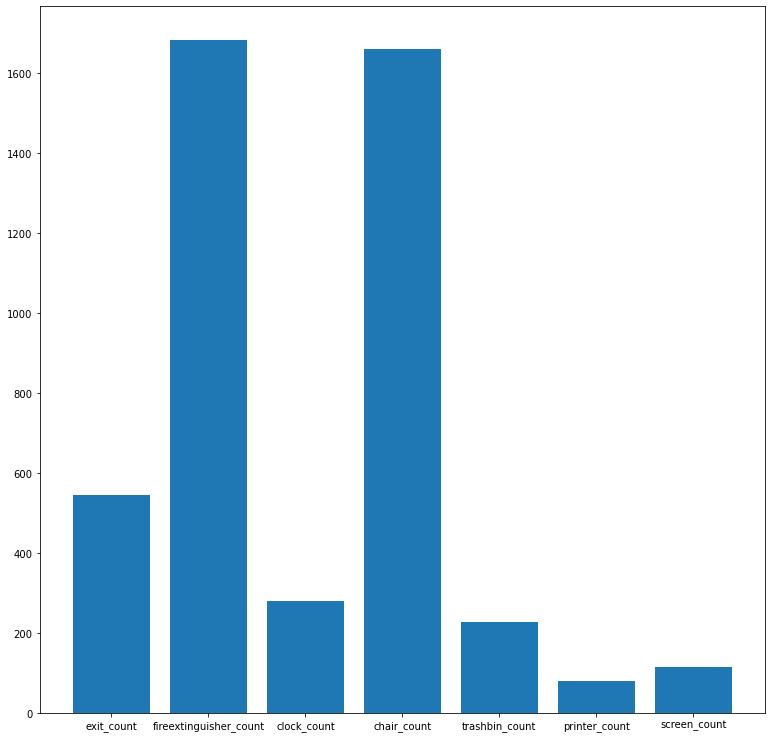

In [464]:
plt.figure(figsize=(13,13))
plt.bar(col_counts,count_list)
plt.show()

count how many files contain multiple objects. We need to know this before splitting the dataset with equally frequent classes

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


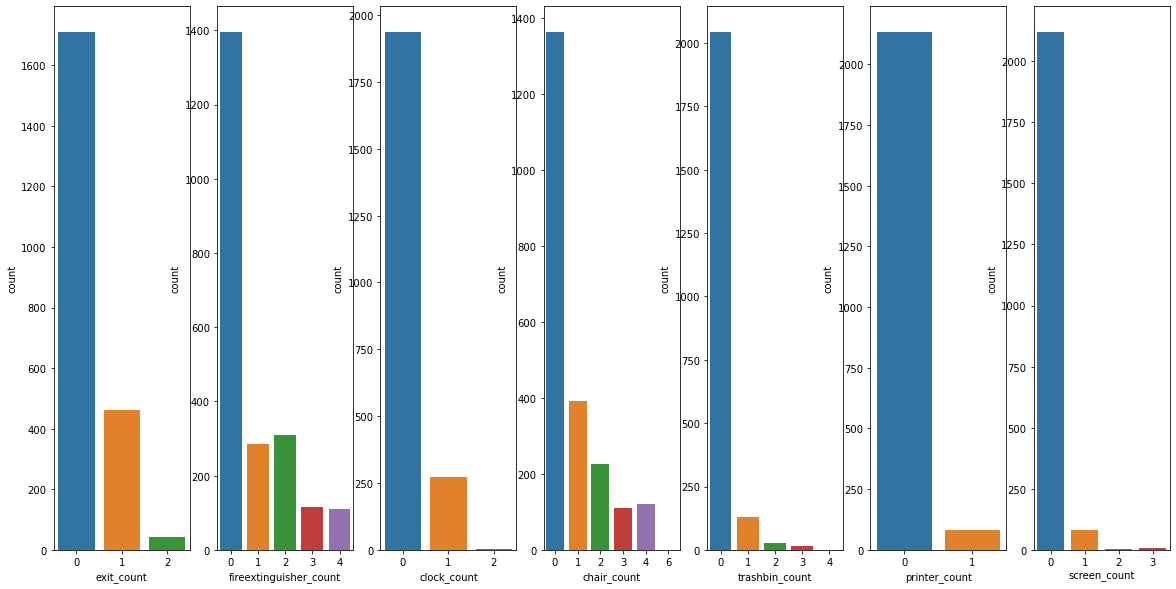

In [465]:

fig, ax =plt.subplots(1,len(col_counts),figsize=(20, 10))

for i,col in enumerate(col_counts):
  sns.countplot(x=col_counts[i], data=df, ax=ax[i])

fig.show()

As the first thing, we extract all the rows with more than 1 object labeled. These are the records we can play with for levelling all the classes.

In [466]:
file_with_multi_obj = []
file_with_no_obj = []

i = 0
for index, row in df.iterrows():
  count = 0
  for col in col_counts:
    if( df.iloc[i][col] > 0):
      count += 1
  if(count > 1):
    file_with_multi_obj.append(i)
  elif(count == 0):
    file_with_no_obj.append(i)
  i += 1

In [467]:
len(file_with_multi_obj),(len(file_with_multi_obj)*100)/len(df)

(478, 21.599638499774063)

records with more than two classes are 20% of the dataset (we may include them in the valid and test set)

In [468]:
(len(df)*1.60)/100 

35.408

35 images (1,60%) of the total images may be used to balance classes with less samples)

In [469]:
df_with_single_r = df.drop(df.index[file_with_multi_obj])
len(df_with_single_r)

1735

we check again the number of occurences for each class: the 35 image may be used to fill the classes trashbin,printer or screen

245 counts for colunm exit_count
1095 counts for colunm fireextinguisher_count
160 counts for colunm clock_count
1506 counts for colunm chair_count
90 counts for colunm trashbin_count
26 counts for colunm printer_count
92 counts for colunm screen_count


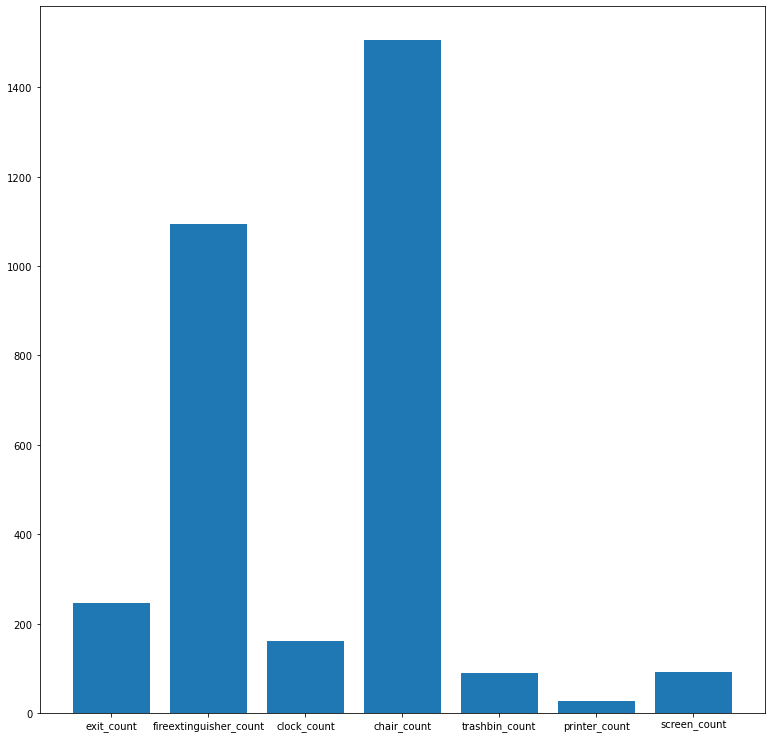

In [470]:
col_counts = ['exit_count','fireextinguisher_count','clock_count','chair_count','trashbin_count',	'printer_count',	'screen_count']
count_list = [] 
for col in col_counts:
  sum = df_with_single_r[col].sum()
  count_list.append(sum)
  print("{} counts for colunm {}".format(sum,col))

plt.figure(figsize=(13,13))
plt.bar(col_counts,count_list)
plt.show()

In [471]:
df_with_multi_objects = df.iloc[file_with_multi_obj]

we look for records with printer and (trashbin or screen) are present

In [472]:
mask = (df_with_multi_objects["printer_count"]>0) & ((df_with_multi_objects["trashbin_count"]>0) | (df_with_multi_objects["screen_count"]>0))
df_with_printer_and_oth = df_with_multi_objects.loc[mask]

In [473]:
df_with_printer_and_oth

,exit,fireextinguisher,clock,chair,trashbin,printer,screen,exit_count,fireextinguisher_count,clock_count,chair_count,trashbin_count,printer_count,screen_count
frame_s2_134.jpg,"[[28, 263, 55, 55]]",NaN,NaN,NaN,"[[312, 507, 123, 217]]","[[281, 813, 331, 435]]",NaN,1,0,0,0,1,1,0
frame_s2_135.jpg,NaN,NaN,NaN,NaN,"[[238, 417, 146, 238]]","[[198, 815, 371, 505]]",NaN,0,0,0,0,1,1,0
frame_s2_136.jpg,NaN,NaN,NaN,NaN,"[[206, 402, 184, 283]]","[[173, 833, 425, 541]]",NaN,0,0,0,0,1,1,0
frame_s2_137.jpg,NaN,NaN,NaN,NaN,"[[161, 290, 172, 268]]","[[86, 797, 440, 631]]",NaN,0,0,0,0,1,1,0
frame_s2_138.jpg,NaN,NaN,NaN,NaN,"[[112, 212, 193, 292]]","[[42, 743, 482, 672]]",NaN,0,0,0,0,1,1,0
frame_s2_139.jpg,NaN,NaN,NaN,NaN,"[[144, 0, 208, 327]]","[[46, 683, 417, 661]]",NaN,0,0,0,0,1,1,0
frame_s2_160.jpg,NaN,NaN,NaN,NaN,"[[83, 153, 147, 239]]","[[48, 495, 297, 508]]",NaN,0,0,0,0,1,1,0
frame_s2_161.jpg,NaN,NaN,NaN,NaN,"[[29, 17, 233, 300]]","[[2, 481, 424, 584]]",NaN,0,0,0,0,1,1,0
frame_s3_10.jpg,NaN,NaN,NaN,NaN,"[[149, 702, 187, 410]]","[[67, 347, 356, 560]]",NaN,0,0,0,0,1,1,0
frame_s3_11.jpg,NaN,NaN,NaN,NaN,"[[152, 724, 189, 420]]","[[65, 358, 364, 579]]",NaN,0,0,0,0,1,1,0


300 counts for colunm exit_count
589 counts for colunm fireextinguisher_count
120 counts for colunm clock_count
156 counts for colunm chair_count
138 counts for colunm trashbin_count
55 counts for colunm printer_count
23 counts for colunm screen_count


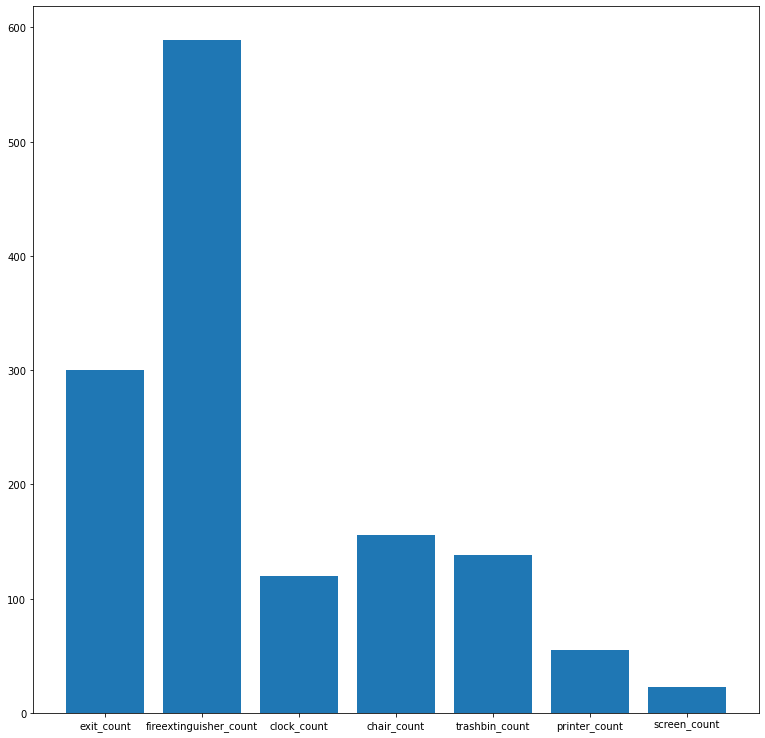

In [474]:
col_counts = ['exit_count','fireextinguisher_count','clock_count','chair_count','trashbin_count',	'printer_count',	'screen_count']
count_list = [] 
for col in col_counts:
  sum = df_with_multi_objects[col].sum()
  count_list.append(sum)
  print("{} counts for colunm {}".format(sum,col))

plt.figure(figsize=(13,13))
plt.bar(col_counts,count_list)
plt.show()

In order to have every class for each split, I sample before from the dataframe with only one labeled class per image.

In [475]:
i = 0
for col in ['exit',	'fireextinguisher'	,'clock'	,'chair' ,'trashbin'	,'printer'	,'screen']:
  
  mask = (df_with_single_r[ col + "_count"] >0)
  temp_df = df_with_single_r.loc[mask]

  train_samples,val_samples,test_samples = math.ceil((len(temp_df)*80)/100), math.ceil((len(temp_df)*10)/100), math.ceil((len(temp_df)*10)/100)
  train_df_temp = temp_df.sample(n=train_samples) 

  temp_df = temp_df[~temp_df.index.isin(train_df_temp.index)]
  val_df_temp = temp_df.sample(n=val_samples) 
  test_df_temp = temp_df[~temp_df.index.isin(val_df_temp.index)]
  print("{} {} {}".format(len(train_df_temp),len(val_df_temp),len(test_df_temp)))
  if(i == 0):
    train_df = train_df_temp.copy()
    val_df = val_df_temp.copy()
    test_df = test_df_temp.copy()
  else:
    train_df = train_df.append(train_df_temp)
    val_df = val_df.append(val_df_temp)
    test_df = test_df.append(test_df_temp)

  i += 1


181 23 22
382 48 47
126 16 15
560 70 69
59 8 6
21 3 2
57 8 6


we chech the size of each split

In [476]:
len(train_df),len(val_df),len(test_df)

(1386, 176, 167)

In [477]:
len(df_with_multi_objects)

478

We can now sample from the dataframe with mulitple objects

In [478]:
train_samples,val_samples,test_samples = math.ceil((len(df_with_multi_objects)*80)/100), math.ceil((len(df_with_multi_objects)*10)/100), math.ceil((len(df_with_multi_objects)*10)/100)
train_df_temp = df_with_multi_objects.sample(n=train_samples) 

temp_df = df_with_multi_objects[~df_with_multi_objects.index.isin(train_df_temp.index)]
val_df_temp = temp_df.sample(n=val_samples) 
test_df_temp = temp_df[~temp_df.index.isin(val_df_temp.index)]

train_df = train_df.append(train_df_temp)
val_df = val_df.append(val_df_temp)
test_df = test_df.append(test_df_temp)

we chech the size of each split again

In [479]:
len(train_df),len(val_df),len(test_df)

(1769, 224, 214)

6 images are missing. Why? Because they have no labels (which can be useful tu use as true negatives)


In [480]:
len(file_with_no_obj)

6

In [481]:
df.iloc[0]

exit                      [[244, 500, 192, 99], [358, 742, 218, 105]]
fireextinguisher                                                  NaN
clock                                                             NaN
chair                                                             NaN
trashbin                                                          NaN
printer                                                           NaN
screen                                                            NaN
exit_count                                                          2
fireextinguisher_count                                              0
clock_count                                                         0
chair_count                                                         0
trashbin_count                                                      0
printer_count                                                       0
screen_count                                                        0
Name: frame_s1_1.jpg

We create the annotations needed to train yolo 5

In [580]:
import cv2 as cv

OD_CLASSES = ['exit',	'fireextinguisher'	,'clock'	,'chair' ,'trashbin'	,'printer'	,'screen']



def convert_to_coco_format(df,set_type):

  i = 0
  for index, row in df.iterrows():
    # print('sequence_' +  df.iloc[i].name.split('_')[1][1])
    #we grab the sequence number reprenting the folder where the image is stored
    image_foldername = 'sequence_' +  df.iloc[i].name.split('_')[1][1]
    #read the image
    img = cv.imread('./dataset/' + image_foldername + '/' + df.iloc[i].name)
    cv.imwrite('./dataset/images/' + os.path.join(set_type,df.iloc[i].name) , img)
    #get its props
    height,width = img.shape[:2]
    #we will store every annotation found 
    annotations_list = []
    for col in OD_CLASSES:
      if( isinstance(df.iloc[i][col], list)):
        # print(df.iloc[i][col])
        try:
          for el in df.iloc[i][col]:
            cv.rectangle(img, (int(el[1]), int(el[0])), (int(el[1])+int(el[2]), int(el[0])+int(el[3])), (0,255,0), 1)
            centerX,centerY = (int(el[0]) + (int(el[3])/2)), ( int(el[1]) + (int(el[2])/2))
            centerX,centerY,w,h = centerX/width,centerY/height,int(el[3])/width,int(el[2])/height
            annotations = [OD_CLASSES.index(col),round(centerX,3),round(centerY,3),round(w,3),round(h,3)]
            annotations_list.append(annotations)
            # print(OD_CLASSES.index(col),centerX,centerY,w,h)
        except Exception:
          continue

    with open('./dataset' + '/coco/' + os.path.join(set_type, df.iloc[i].name.split('.')[0]) + ".txt", "w") as annFile:
      for ann in annotations_list:
        annotation_string = " ".join(str(item) for item in ann)
        annFile.write("%s \n" % annotation_string)
    i += 1


  #debugging purposes
  # plt.figure(figsize=(20,20))
  # plt.imshow(img)
  # plt.show()  
    # print(col,df.iloc[0][col])




In [581]:
convert_to_coco_format(train_df,'train')
convert_to_coco_format(val_df,'valid')
convert_to_coco_format(test_df,'test')

Checking whether the annotation's convertion to coco format are correct

(196, 210) (420, 630)
(404, 130) (685, 672)
(694, 117) (1008, 683)


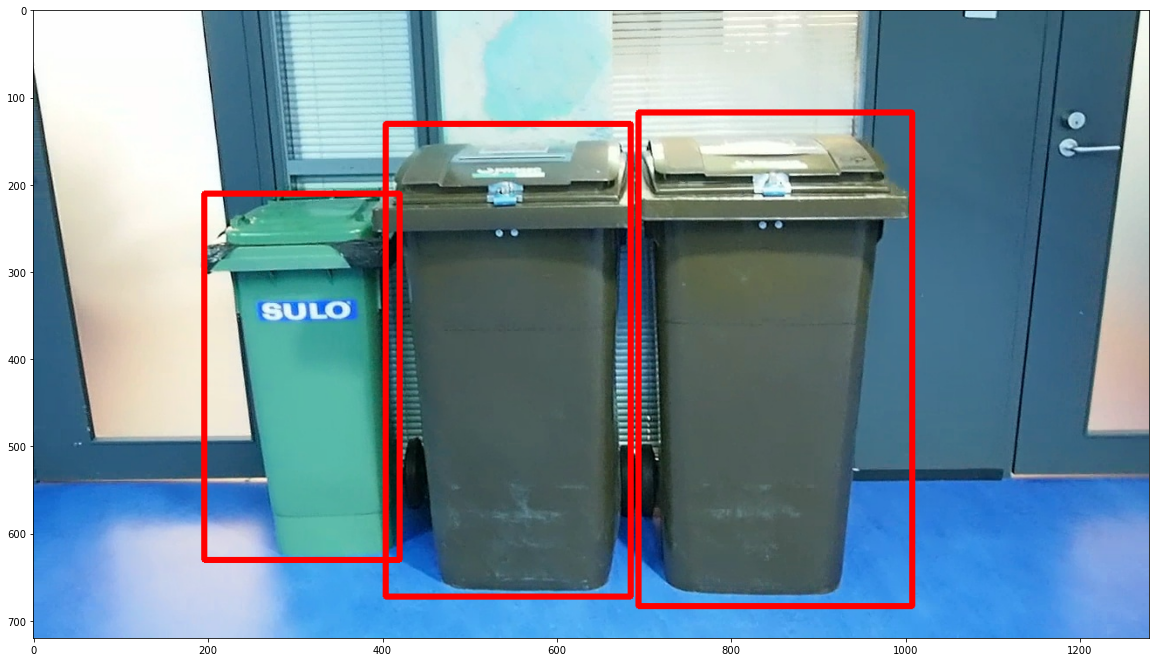

In [579]:

img = cv.imread('D:/projects/yolo 5/dataset/images/valid/frame_s3_30.jpg')
imgHeight,imgWidth = img.shape[:2]
with open('D:/projects/yolo 5/dataset/coco/valid/frame_s3_30'+ ".txt", "r") as annFile:
  lines = annFile.readlines()
  for line in lines:
      line = line.split(' ')

      number,centerX,centerY,width,height,_ = line[:]
      centerX = (float(imgWidth) * float(centerX)) 
      centerY = (float(imgHeight) * float(centerY)) 
      width = (float(imgWidth) * float(width)) 
      height = (float(imgHeight) * float(height)) 

      print(( math.ceil(centerY-(height/2) ), math.ceil(centerX-(width/2)) ), \
                        ( math.ceil(centerY + (height/2)), math.ceil(centerX + (width/2)) ))
      cv.rectangle(img, ( math.ceil(centerY-(height/2) ), math.ceil(centerX-(width/2)) ), \
                        ( math.ceil(centerY + (height/2)), math.ceil(centerX + (width/2)) ) , (255,0,0) ,5) 

plt.figure(figsize=(20,20))
plt.imshow(img)

In [548]:
centerX,centerY = (int(el[0]) + (int(el[3])/2)), ( int(el[1]) + (int(el[2])/2))
centerX,centerY,w,h = centerX/width,centerY/height,int(el[2])/width,int(el[3])/height

(720, 1280)